In [1]:
import os
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_and_optimize_and_sample_petri_model,
    load_and_calibrate_and_optimize_and_sample_petri_model
)
import numpy as np
from pyciemss.visuals import plots

In [2]:
ASKENET_PATH = "https://data-service.staging.terarium.ai/models/ada3d20a-cbc8-4bbd-b6b3-76446fb3cfdb"

In [54]:
from mira.sources.askenet.petrinet import model_from_url
from mira.metamodel import Distribution

model = model_from_url(ASKENET_PATH)

model.parameters['lambda'].value = 9.06e-8
model.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0, "maximum":2 * 9.06e-8})
# model.parameters['lambda'].value
model.parameters['gamma'].value = 0.125
model.parameters['beta'].value = 44852600

model.initials['E'].value = 1182

In [55]:
num_samples = 3
timepoints = [i for i in range(1, 100, 1)]

# Run sampling w/o an intervention
result = load_and_sample_petri_model(model, num_samples, timepoints=timepoints, method="euler")

In [56]:
# Display the top 300 cells of this dataframe
import pandas as pd

data_path = "notebook/july_evaluation_true/dataset.csv"
data = pd.read_csv(data_path, index_col="time")
data["V"] = data['viral_load'].cumsum()

In [57]:
data.drop(columns=["viral_load"], inplace=True)

In [58]:
data

,V
time,
0,3.424864e+13
1,7.482611e+13
2,1.107730e+14
3,1.455132e+14
4,1.789461e+14
...,...
221,1.256720e+17
222,1.257698e+17
223,1.258096e+17


In [66]:
data_end_point = 77

train_path = "notebook/july_evaluation_true/processed_dataset_train.csv"
test_path = "notebook/july_evaluation_true/processed_dataset_test.csv"
data[:data_end_point].to_csv(train_path)
data[data_end_point:].to_csv(test_path)

/Users/sam-basis/opt/anaconda3/envs/pyciemss-deriv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'timepoint_id')

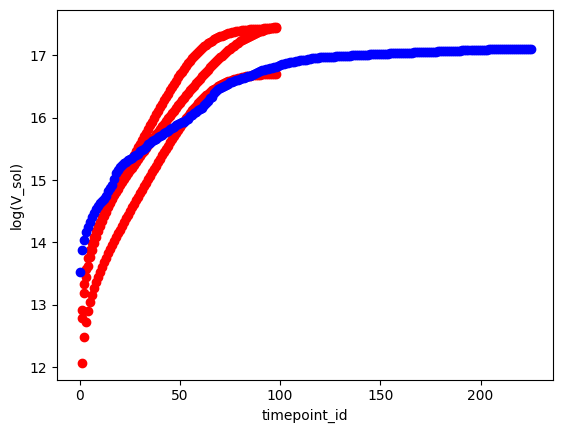

In [60]:
import matplotlib.pyplot as plt
import numpy as np


plt.scatter(result['data']['timepoint_id'], np.log10(result['data']['V_sol']), color='red', label="simulation")
plt.scatter(data.index, np.log10(data['V']), color='blue')
plt.ylabel('log(V_sol)')
plt.xlabel('timepoint_id')

In [68]:
timepoints_cal = [i for i in range(1, 113, 1)]

result_cal = load_and_calibrate_and_sample_petri_model(
    model,
    train_path,
    num_samples,
    num_iterations=100,
    timepoints=timepoints,
    verbose=True,
    noise_scale=1.,
    method="euler"
)

/Users/sam-basis/Desktop/Research/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:753: UserWarning: Observation ObservationEvent(time=1.0317422493244521e-05, observation={'V': tensor(3.4249e+13)}) is not in the range [0, 2301182.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/sam-basis/Desktop/Research/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:753: UserWarning: Observation ObservationEvent(time=1.0000067949295044, observation={'V': tensor(7.4826e+13)}) is not in the range [0, 2301182.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/sam-basis/Desktop/Research/pyciemss/src/pyciemss/PetriNetODE/interfaces.py:753: UserWarning: Observation ObservationEvent(time=2.0000014305114746, observation={'V': tensor(1.1077e+14)}) is not in the range [0, 2301182.0]. This may be an error!
  warnings.warn(f"Obs

iteration 0: loss = 4.430114867239715e+18
iteration 25: loss = 4.430114317483901e+18
iteration 50: loss = 4.430114042605994e+18
iteration 75: loss = 4.430113767728087e+18


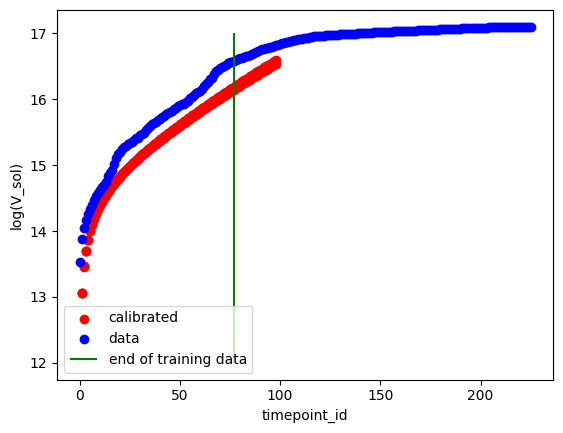

In [73]:
plt.scatter(result_cal['data']['timepoint_id'], np.log10(result['data']['V_sol']), color='red', label="calibrated")
plt.scatter(data.index, np.log10(data['V']), color='blue', label="data")
plt.vlines(x=data_end_point, ymin=12., ymax=17., color='green', label="end of training data")
plt.ylabel('log(V_sol)')
plt.xlabel('timepoint_id')
plt.legend()

In [86]:
lambda_min = result_cal['data']['lambda_param'].min()
lambda_max = result_cal['data']['lambda_param'].max()

## STAGE 2

In [90]:
from mira.sources.askenet.petrinet import model_from_url
from mira.metamodel import Distribution

model = model_from_url(ASKENET_PATH)

model.parameters['lambda'].value = 9.06e-8
model.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": lambda_min, "maximum":lambda_max})
# model.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0, "maximum":2 * 9.06e-8})
model.parameters['gamma'].value = 0.125
model.parameters['beta'].value = 44852600
model.parameters['alpha'].distribution = Distribution(type="Uniform1", parameters={"minimum": 51, "maximum":796})

model.initials['E'].value = 1182

In [91]:
result = load_and_sample_petri_model(model, num_samples, timepoints=timepoints, method="euler", visual_options={"title": "Intervened SIR Model", "subset":".*_sol"})

In [92]:
plots.ipy_display(result["visual"])